<a href="https://colab.research.google.com/github/pankajr141/experiments/blob/master/Reasoning/GAN/GAN_103_WGAN_GP_Mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Wasserstein GAN with Gradient Penalty (WGAN-GP)

The notebook enhances GAN 102 by replacing the BCE loss function by EMD (Earth mover distance) implementaion using WGAN-GP

Here are the main features of WGAN-GP

* Resolves issues with the GANs that you have been using up until this point. 
* Implements W-loss, where W stands for Wasserstein, and gradient penalties to prevent mode collapse.
* Disciminator class is replaced by critic. As discriminator output (0,1) but critic can output any number

---

### Task
MNIST Digit generation, build and train a Deep Convolution GAN that can generate hand-written images of digits (0-9).

### Reference
https://github.com/sahilkhose/Generative-Adversarial-Networks-GANs-Specialization/blob/main/course1/week3/C1W3_WGAN_GP.ipynb

## Generator

Generator class. It will take 3 values:

    The noise vector dimension
    The image dimension
    The initial hidden dimension


In [ ]:
import torch
from torch import nn

class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim

        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU()
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh()
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Critic

The second component that you need to construct is the critic. 

will use 3 layers in your discriminator's neural network.

In [ ]:
class Critic(nn.Module):
    '''
    Critic Class
    Values:
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
    hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Critic, self).__init__()
        self.crit = nn.Sequential(
            self.make_crit_block(im_chan, hidden_dim),
            self.make_crit_block(hidden_dim, hidden_dim * 2),
            self.make_crit_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_crit_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )
        else: # Final Layer
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride)
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        crit_pred = self.crit(image)
        return crit_pred.view(len(crit_pred), -1)

## Training

set your parameters:
As usual, you will start by setting the parameters:
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   beta_1, beta_2: the momentum terms
  *   c_lambda: weight of the gradient penalty
  *   crit_repeats: number of times to update the critic per generator update - there are more details about this in the *Putting It All Together* section
  *   device: the device type



In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST # Training dataset
from torchvision import transforms

z_dim = 64
batch_size = 128
lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
c_lambda = 10
crit_repeats = 5
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# You can tranform the image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

# Load MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


initialize your generator, discriminator, and optimizers.

In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
crit = Critic().to(device) 
crit_opt = torch.optim.Adam(crit.parameters(), lr=lr, betas=(beta_1, beta_2))

# initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
  
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
crit = crit.apply(weights_init)

#### Gradient Penalty

In order to Ensure L1 continuity for critic for underlying EMD(Earth Mover Distance), we can do eigher
1. we can eigther clip the weight of critic n/w 
2. Add regularization term to the Loss function i.e add gradient penalty

Calculating the gradient penalty can be broken into two functions: (1) compute the gradient with respect to the images and (2) compute the gradient penalty given the gradient.

You can start by getting the gradient. The gradient is computed by first creating a mixed image. This is done by weighing the fake and real image using epsilon and then adding them together. Once you have the intermediate image, you can get the critic's output on the image. Finally, you compute the gradient of the critic score's on the mixed images (output) with respect to the pixels of the mixed images (input).

In [ ]:
def get_gradient(crit, real, fake, epsilon):
    '''
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        crit: the critic model
        real: a batch of real images
        fake: a batch of fake images
        epsilon: a vector of the uniformly random proportions of real/fake per mixed image
    Returns:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    '''
    # Mix the images together
    mixed_images = real * epsilon + fake * (1 - epsilon)

    # Calculate the critic's scores on the mixed images
    mixed_scores = crit(mixed_images)
    
    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        # Note: We need to take the gradient of outputs with respect to inputs.
        inputs=mixed_images,
        outputs=mixed_scores,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient


The second function we need to complete is to compute the gradient penalty given the gradient. First, we  will calculate the magnitude of each image's gradient. The magnitude of a gradient is also called the norm. Then, we will calculate the penalty by squaring the distance between each magnitude and the ideal norm of 1 and taking the mean of all the squared distances.

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of image gradients, you calculate the magnitude of each image's gradient
    and penalize the mean quadratic distance of each magnitude to 1.
    Parameters:
        gradient: the gradient of the critic's scores, with respect to the mixed image
    Returns:
        penalty: the gradient penalty
    '''
    # Flatten the gradients so that each row captures one image
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    gradient_norm = gradient.norm(2, dim=1)
    
    # Penalize the mean squared distance of the gradient norms from 1
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

#### Losses


calculate the loss for the generator and the critic.

For the generator, the loss is calculated by maximizing the critic's prediction on the generator's fake images. The argument has the scores for all fake images in the batch, but we will use the mean of them.

In [ ]:
def get_gen_loss(crit_fake_pred):
    '''
    Return the loss of a generator given the critic's scores of the generator's fake images.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
    Returns:
        gen_loss: a scalar loss value for the current batch of the generator
    '''
    gen_loss = -torch.mean(crit_fake_pred)
    return gen_loss


For the critic, the loss is calculated by maximizing the distance between the critic's predictions on the real images and the predictions on the fake images while also adding a gradient penalty. The gradient penalty is weighed according to lambda. 

In [ ]:
def get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda):
    '''
    Return the loss of a critic given the critic's scores for fake and real images,
    the gradient penalty, and gradient penalty weight.
    Parameters:
        crit_fake_pred: the critic's scores of the fake images
        crit_real_pred: the critic's scores of the real images
        gp: the unweighted gradient penalty
        c_lambda: the current weight of the gradient penalty 
    Returns:
        crit_loss: a scalar for the critic's loss, accounting for the relevant factors
    '''
    crit_loss = torch.mean(crit_fake_pred) - torch.mean(crit_real_pred) + c_lambda * gp
    return crit_loss

#### Helper functions

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np

def show_tensor_images(image_tensor1, image_tensor2, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_real = image_tensor1.detach().cpu().view(-1, *size)
    image_grid_real = make_grid(image_real[:num_images], nrow=5)
    image_grid_real = image_grid_real.permute(1, 2, 0).squeeze()

    image_fake = image_tensor2.detach().cpu().view(-1, *size)
    image_grid_fake = make_grid(image_fake[:num_images], nrow=5)
    image_grid_fake = image_grid_fake.permute(1, 2, 0).squeeze()
    img_sep = torch.ones(image_grid_fake.shape[1], 10 , image_grid_fake.shape[2])
    #print(img_sep)
    image_grid = np.concatenate([image_grid_real, img_sep, image_grid_fake], axis=1)
    plt.imshow(image_grid)
    plt.show()

#### Putting It All Together

1.   Even on GPU, the **training will run more slowly** than previous labs because the gradient penalty requires you to compute the gradient of a gradient -- this means potentially a few minutes per epoch! For best results, run this for as long as you can while on GPU.
2.   One important difference from earlier versions is that you will **update the critic multiple times** every time you update the generator This helps prevent the generator from overpowering the critic. Sometimes, you might see the reverse, with the generator updated more times than the critic. This depends on architectural (e.g. the depth and width of the network) and algorithmic choices (e.g. which loss you're using). 
3.   WGAN-GP isn't necessarily meant to improve overall performance of a GAN, but just **increases stability** and avoids mode collapse. In general, a WGAN will be able to train in a much more stable way than the vanilla DCGAN from last assignment, though it will generally run a bit slower. You should also be able to train your model for more epochs without it collapsing.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 1000: Generator loss: 0.22395827864925377, critic loss: -1.1555928012251857


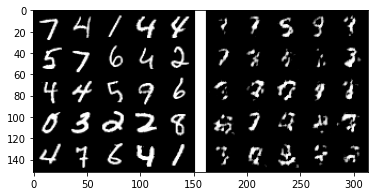

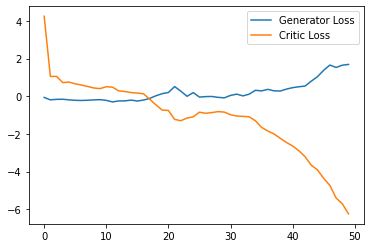

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 2000: Generator loss: -1.5572385002058, critic loss: -11.263988647091367


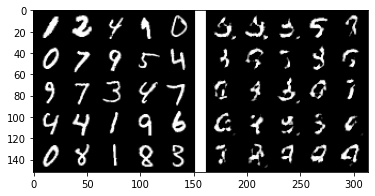

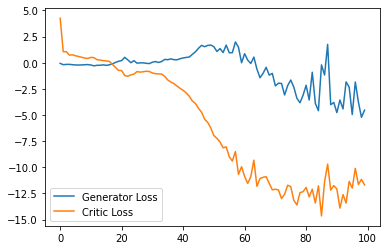

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 3000: Generator loss: -8.282302299201488, critic loss: -11.84956379801033


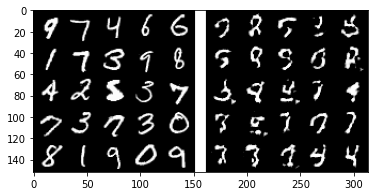

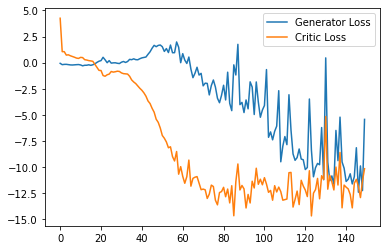

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 4000: Generator loss: -10.541216264277697, critic loss: -13.305935746490944


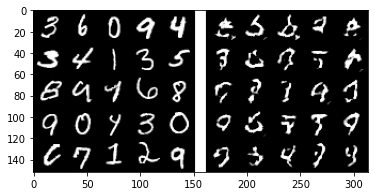

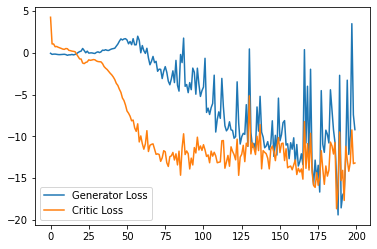

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 5000: Generator loss: -7.261184608571232, critic loss: -0.631631305766107


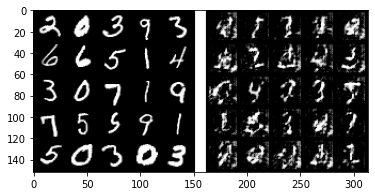

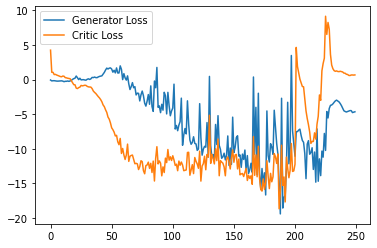

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 6000: Generator loss: -3.1368967921733857, critic loss: 0.033090029233694085


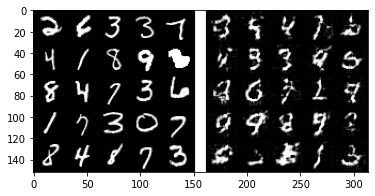

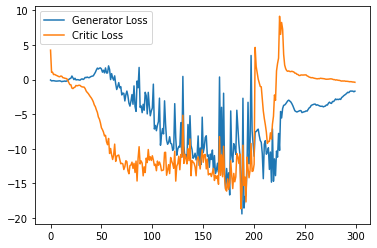

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 7000: Generator loss: -2.232131378054619, critic loss: -0.7483871054232132


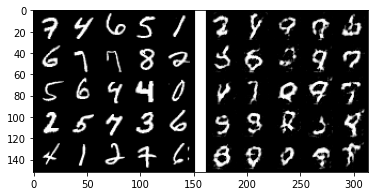

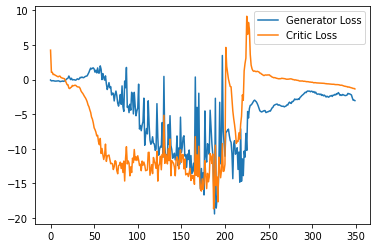

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 8000: Generator loss: -5.046018466472626, critic loss: -1.5135000435993082


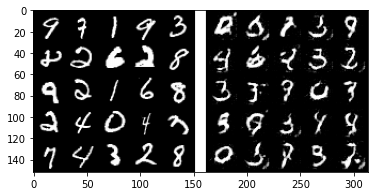

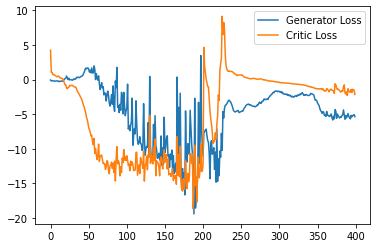

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 9000: Generator loss: -5.7395856916606425, critic loss: -1.5808677808724347


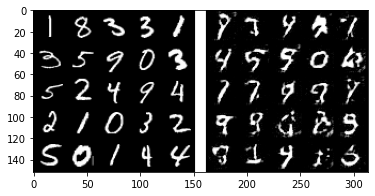

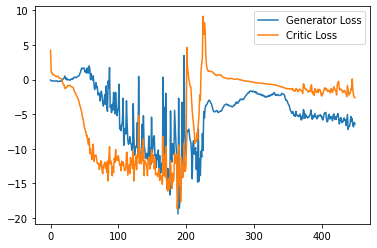

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 10000: Generator loss: -6.981992540359497, critic loss: -0.6346900935381642


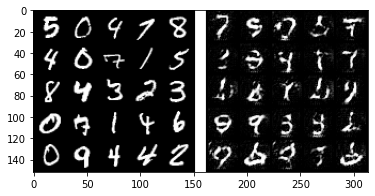

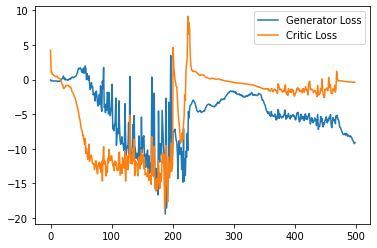

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 11000: Generator loss: -10.3162884683609, critic loss: -0.5460094304904345


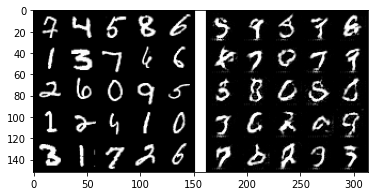

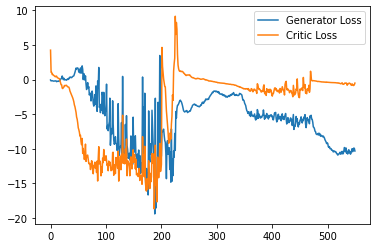

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 12000: Generator loss: -11.765149603843689, critic loss: -0.6930346691980951


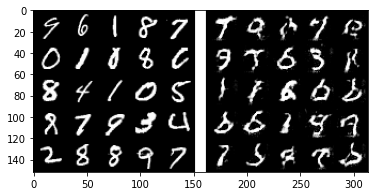

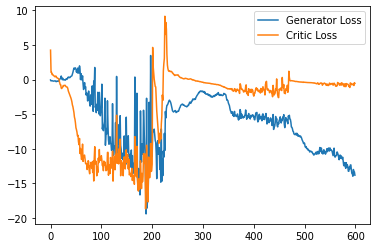

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 13000: Generator loss: -14.891935047149659, critic loss: -0.9825692839130771


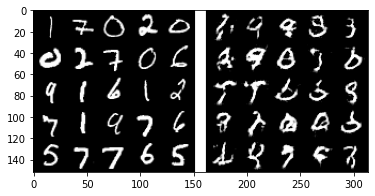

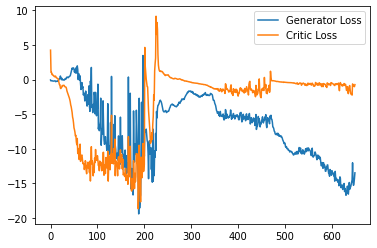

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 14000: Generator loss: -16.158779391288757, critic loss: -0.5125314480029045


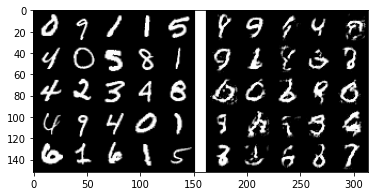

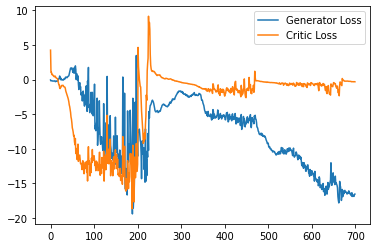

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 15000: Generator loss: -18.198047130584715, critic loss: -0.3559518228981644


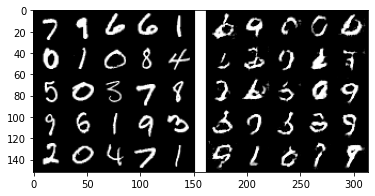

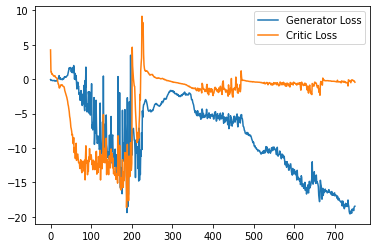

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 16000: Generator loss: -18.529600040435792, critic loss: -0.6117409725047644


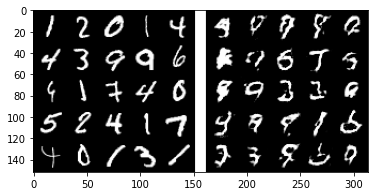

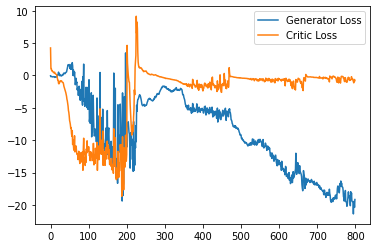

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 17000: Generator loss: -21.687461131095887, critic loss: -0.8718500605084006


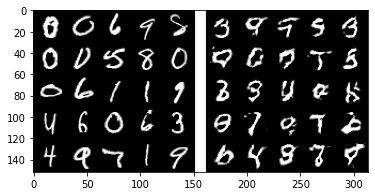

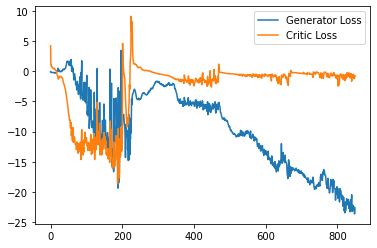

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 18000: Generator loss: -23.6303458070755, critic loss: -1.3593366964273152


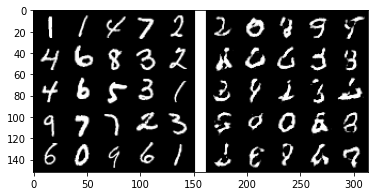

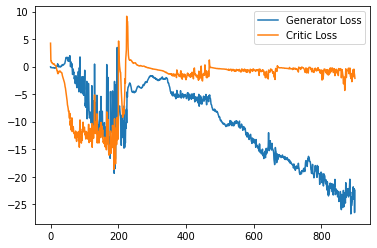

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 19000: Generator loss: -23.21991517162323, critic loss: -1.1547855193525556


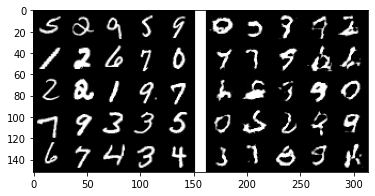

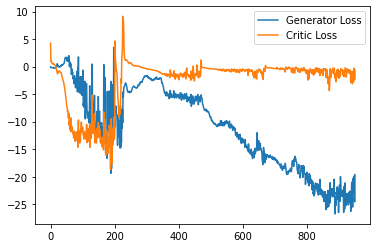

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 20000: Generator loss: -21.868911017894746, critic loss: -1.343106946705281


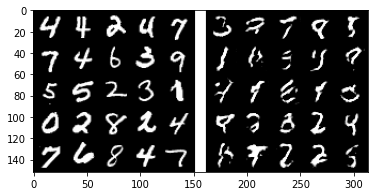

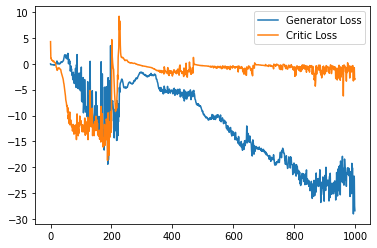

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 21000: Generator loss: -21.97538013136387, critic loss: -1.9246084722340107


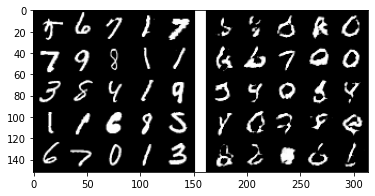

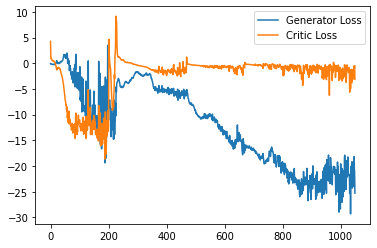

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 22000: Generator loss: -21.25943422794342, critic loss: -1.2632191422492265


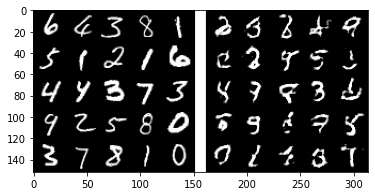

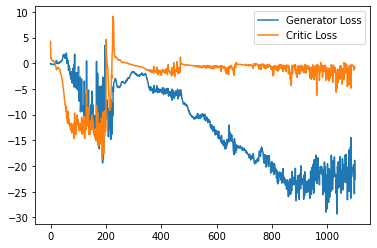

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 23000: Generator loss: -23.714344648122786, critic loss: -2.2665808246016512


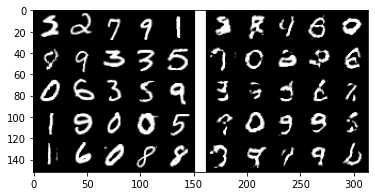

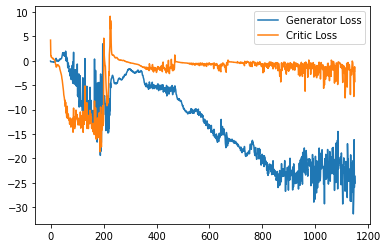

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 24000: Generator loss: -22.835912513315677, critic loss: -1.8504083952799448


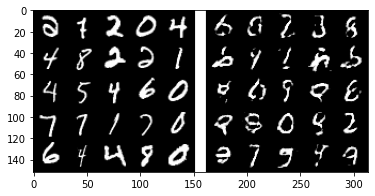

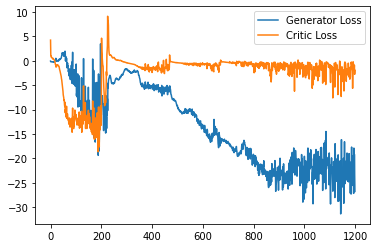

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 25000: Generator loss: -23.724473493739964, critic loss: -2.2330977719441054


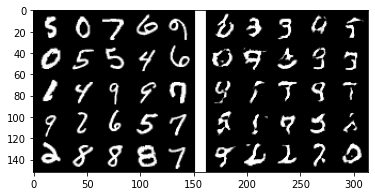

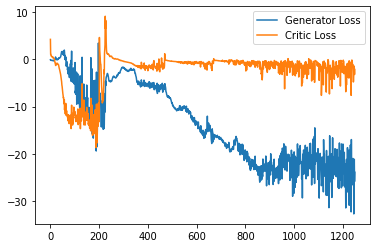

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 26000: Generator loss: -23.102266425937415, critic loss: -2.933470598973332


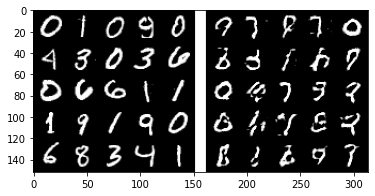

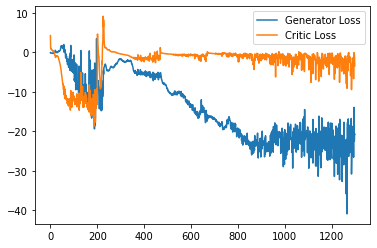

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 27000: Generator loss: -19.069585238456725, critic loss: -2.3508639047794055


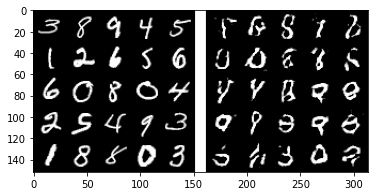

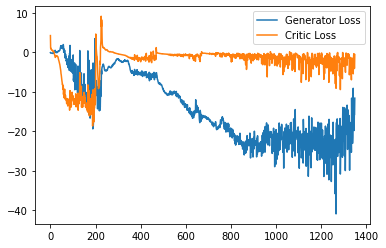

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 28000: Generator loss: -12.785721846669912, critic loss: -2.5061744795084


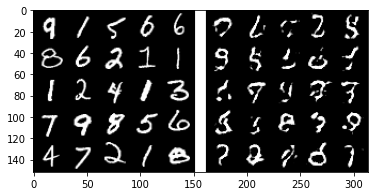

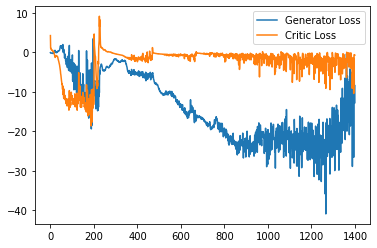

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 29000: Generator loss: -10.36897216648236, critic loss: -2.688801328904928


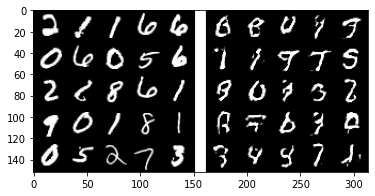

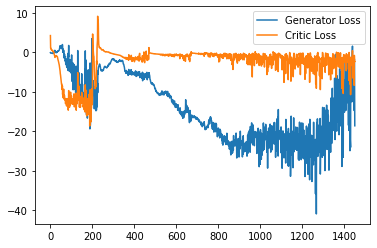

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 30000: Generator loss: -5.937964166283607, critic loss: -2.5710339229866865


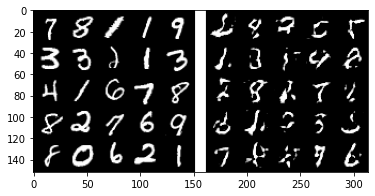

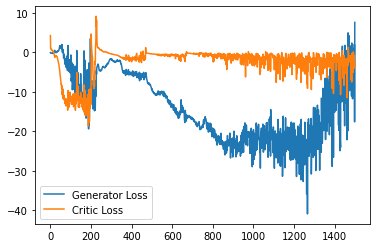

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 31000: Generator loss: -5.572534687139094, critic loss: -3.453498382034901


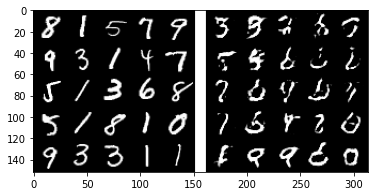

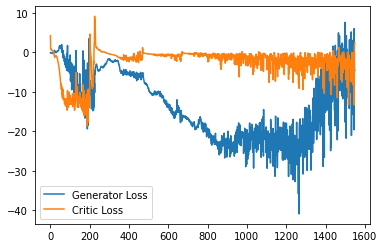

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 32000: Generator loss: -3.569091951150447, critic loss: -1.401889305785298


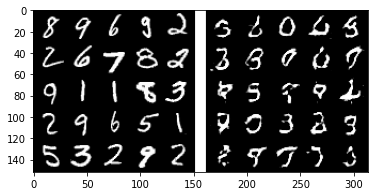

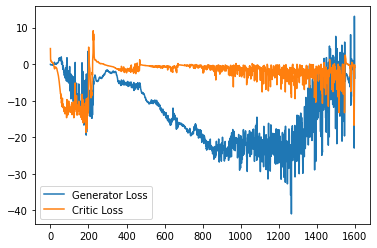

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 33000: Generator loss: -6.309664584346115, critic loss: -3.2348217994943265


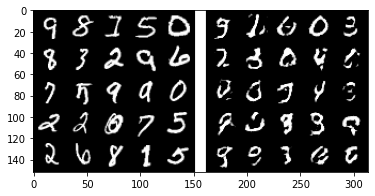

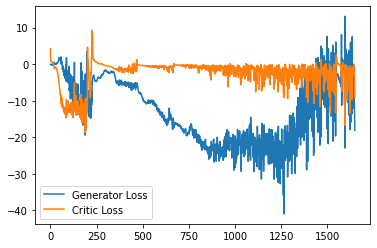

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 34000: Generator loss: -9.118758305512369, critic loss: -3.2537236056819605


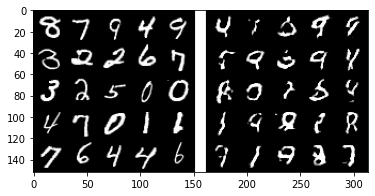

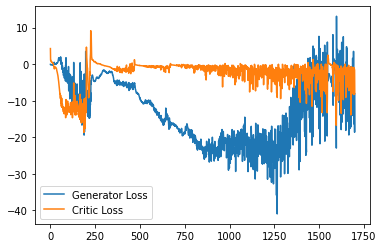

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 35000: Generator loss: -10.773044427841901, critic loss: -3.678463087324793


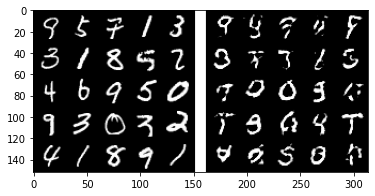

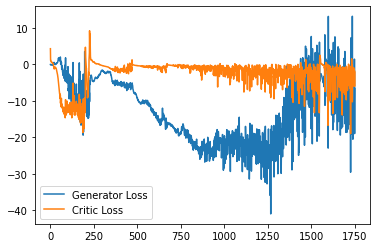

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 36000: Generator loss: -14.541329059787095, critic loss: -3.6673630343481887


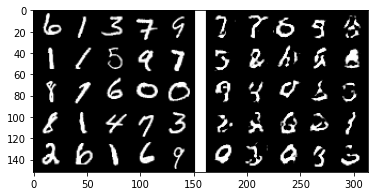

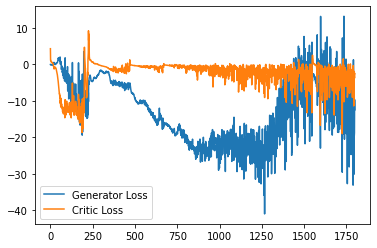

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 37000: Generator loss: -17.497610560439526, critic loss: -4.700909379345175


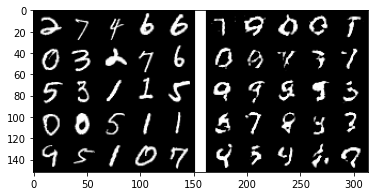

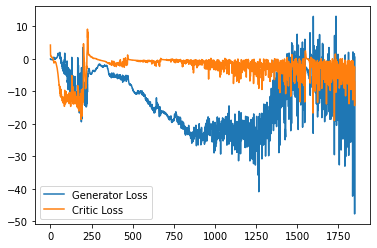

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 38000: Generator loss: -19.94675522582978, critic loss: -5.5211754242703295


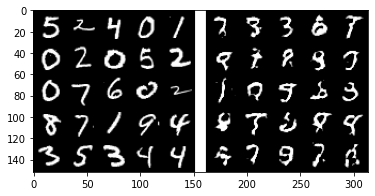

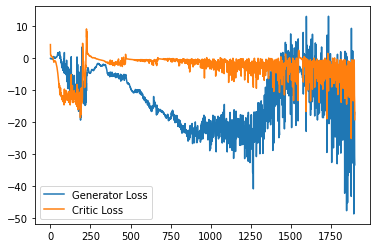

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 39000: Generator loss: -16.879159571737052, critic loss: -5.06729004393965


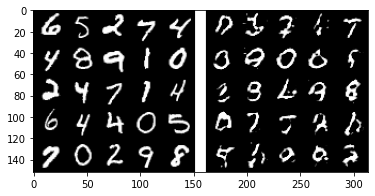

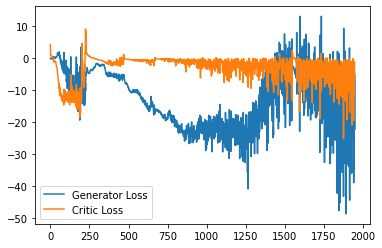

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 40000: Generator loss: -17.82257066118717, critic loss: -5.372927689285577


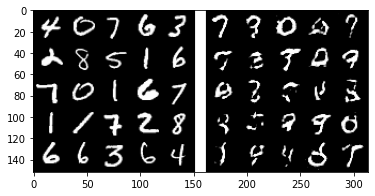

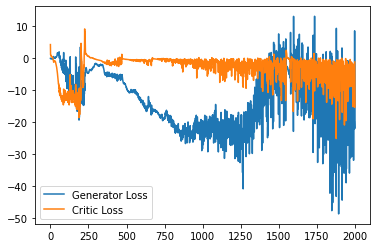

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 41000: Generator loss: -16.94916876807809, critic loss: -6.22259182278663


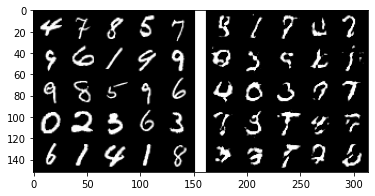

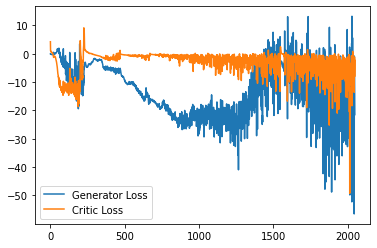

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 42000: Generator loss: -20.493623852521182, critic loss: -7.742185146428647


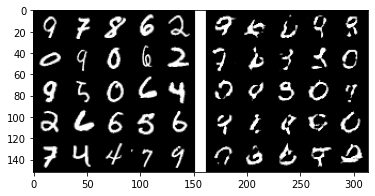

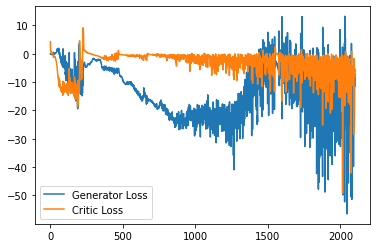

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 43000: Generator loss: -12.563362435430289, critic loss: -7.531409340117858


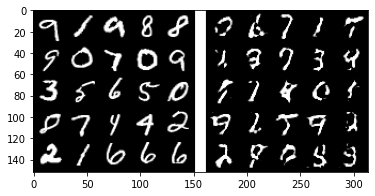

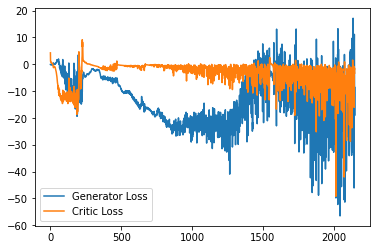

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 44000: Generator loss: -12.074283559836447, critic loss: -8.802678422527014


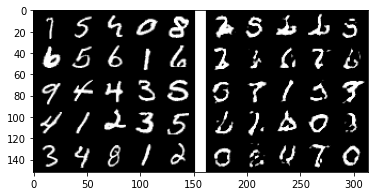

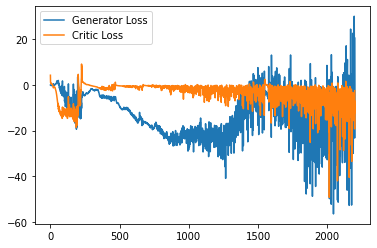

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 45000: Generator loss: -2.0932421940863133, critic loss: -7.807211700782174


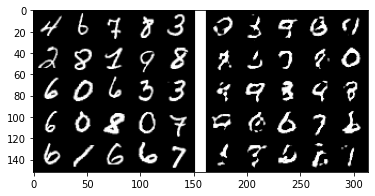

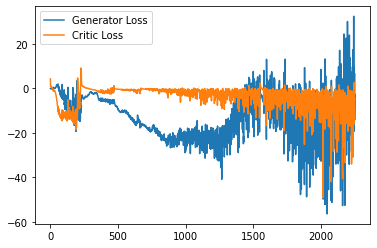

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Step 46000: Generator loss: 1.0117865077201278, critic loss: -11.577546387659


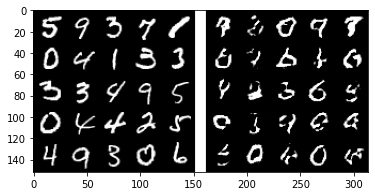

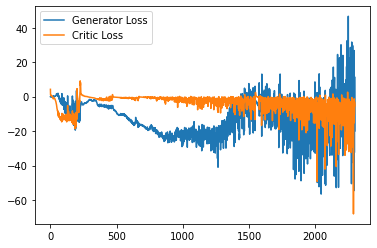

In [ ]:
from tqdm.auto import tqdm

n_epochs = 100
display_step = 1000

cur_step = 0
generator_losses = []
critic_losses = []

for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)


        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):

            ### Update critic ###
            crit_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            crit_fake_pred = crit(fake.detach())
            crit_real_pred = crit(real)

            epsilon = torch.rand(len(real), 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(crit, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            crit_loss = get_crit_loss(crit_fake_pred, crit_real_pred, gp, c_lambda)

            # Keep track of the average critic loss in this batch
            mean_iteration_critic_loss += crit_loss.item() / crit_repeats

            crit_loss.backward(retain_graph=True)
            crit_opt.step()

        critic_losses += [mean_iteration_critic_loss]

        ## Update generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        crit_fake_pred = crit(fake_2)
        
        gen_loss = get_gen_loss(crit_fake_pred)
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        generator_losses += [gen_loss.item()]


        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:            
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            crit_mean = sum(critic_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")

            show_tensor_images(real, fake)

            step_bins = 20
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Critic Loss"
            )
            plt.legend()
            plt.show()
        cur_step += 1